In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 9.1 군집

#### 쓰는곳
1.고객분류 

2.데이터분석 - 군집마다 따로 분석

3.차원축소 - 클러스터에 대한 친화성 벡터로 전환

4.이상치탐지 

5.준지도학습 - 동일한 클러스터에 레이블 전파

6.검색엔진 - 비슷한 이미지 찾아줌

7.이미지분할 - 픽셀을 색에 기반하여 클러스터로 모음. 클러스터의 평균색으로 바꿔줌. 윤곽감지쉬워짐


## 9.1.1 k-mean

In [5]:
from sklearn.datasets import make_blobs

In [6]:
blob_centers = np.array(
[[0.2,2.3],
[-1.5,2.3],
[-2.8,1.8],
[-2.8,2.8],
[-2.8,1.3]]
)

blob_std = np.array([0.4,0.3,0.1,0.1,0.1])



In [7]:
X,y = make_blobs(n_samples=2000, centers = blob_centers,
                cluster_std = blob_std,random_state=7)

In [10]:
def plot_clusters(X,y=None):
    plt.scatter(X[:,0],X[:,1],c=y,s=1)
    plt.xlabel("$x_1$",fontsize=14)
    plt.ylabel("$x_2$",fontsize=14,rotation=0)

그림 저장: blobs_plot


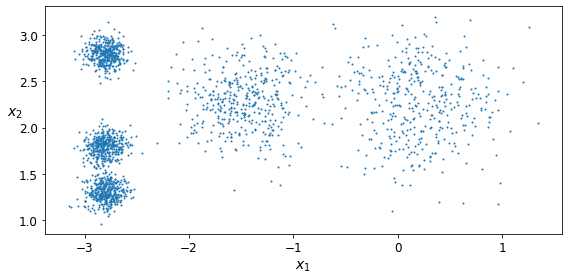

In [11]:
plt.figure(figsize=(8,4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

In [21]:
from sklearn.cluster import KMeans
k=5
kmeans = KMeans(n_clusters=k,random_state=42)
y_pred=kmeans.fit_predict(X)

In [22]:
y_pred

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

In [23]:
#예측된 label이 저장되어있음
kmeans.labels_

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

In [24]:
#센트로이드도 저장되어있음
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

In [25]:
#새로운 샘플에 가장 가까운 클러스터를 할당할 수 있음.
X_new = np.array([[0,2],[3,2],[-3,3],[-3,2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

In [28]:
#샘플과 각 센트로이드 사이의 거리 반환 
kmeans.transform(X_new)

#[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901]
#왼쪽부터 첫번째 ~ 다섯번쨰 센트로이드까지의 거리

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

In [36]:
#센트로이드 초기화 방법

#1. 다른 군집화 방법으로 센트로이드를 구한 후 진행
good_init = np.array([[-3,3],[-3,2],[-3,1],[-1,2],[0,2]])
kmeans = KMeans(n_clusters=5,init=good_init,n_init=1,random_state=42)
kmeans.fit(X)
#good_init으로 초기화, 이너셔를 비교하며 초기화하는 횟수 = n_init

KMeans(algorithm='auto', copy_x=True,
       init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       max_iter=300, n_clusters=5, n_init=1, n_jobs=None,
       precompute_distances='auto', random_state=42, tol=0.0001, verbose=0)

In [37]:
#2.여러번 초기화 후 최소 이너셔값

kmeans.inertia_

211.5985372581684

In [38]:
kmeans.score(X)
#.score(X)는 이너셔의 음수값 반환
#why?? --> 사이킷런은 큰값이 좋은 것이다 규칙을 따르기 떄문!!!

-211.59853725816845

#### 미니배치 k-means

In [42]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [43]:
minibatch_kmeans.inertia_

211.97199677202414

#### 최적의 클러스터 수 찾기

In [44]:
#1. k대비 이너셔 그래프에서 "엘보" 찾기

In [46]:
#2. 실루엣스코어

from sklearn.metrics import silhouette_score
silhouette_score(X,kmeans.labels_)

0.655517642572828

## 9.1.3 군집을 사용한 이미지 분할

In [48]:
#이미지 분할은 이미지를 세그먼트 여러개로 분류
#시맨틱 분할은 같은 종류 물체는 같은 세그먼트로 분류

#색상분할정도는 군집으로 쉽게 가능 ex)인공위성 사진에서 산림면적 구하기

In [50]:
# 무당벌레 이미지를 다운로드합니다
import urllib.request
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x7fa5e197c3d0>)

In [51]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [58]:
X=image.reshape(-1,3)
kmeans = KMeans(n_clusters=8).fit(X)


In [61]:
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
#cluster_centers_ 는 센트로이드들
#해당 클러스터에 해당하는 샘플들을 전부 센트로이드로 바꿈.
segmented_img = segmented_img.reshape(image.shape)
#다시 이미지로

In [62]:
segmented_imgs = []
n_colors = (10,8,6,4,2)

for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

그림 저장: image_segmentation_diagram


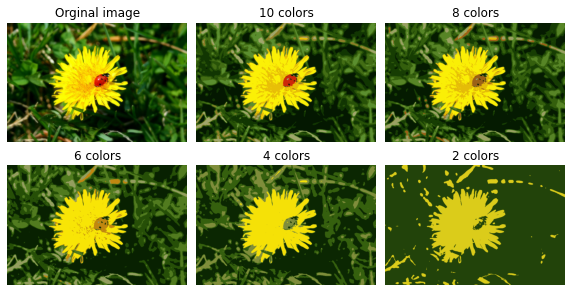

In [63]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Orginal image")
plt.axis("off")

for idx,n_clusters in enumerate(n_colors):
    plt.subplot(232+idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis("off")
    
save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

#### 클러스터 수 (색상 수)를 줄일수록 무당벌레를 독자적인 컬러군집으로 만들지 못함 : 전체에서 비중이 작기때문

## 9.1.4 군집을 사용한 전처리

#### 전처리 전 로지스틱회귀

In [64]:
from sklearn.datasets import load_digits

X_digits,y_digits = load_digits(return_X_y=True)

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
X_train,X_test,y_train,y_test = train_test_split(X_digits,y_digits,random_state=42)

In [67]:
from sklearn.linear_model import LogisticRegression

In [73]:

log_reg = LogisticRegression(multi_class="ovr",solver="lbfgs",max_iter=5000,random_state=42)
log_reg.fit(X_train,y_train)
#ovr은 이진분류기 여러개 학습해서 가장 높은점수.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
log_reg.score(X_test,y_test)

0.9688888888888889

#### 전처리 후 로지스틱회귀

In [76]:
from sklearn.pipeline import Pipeline

#50개 클러스터까지의 거리로 전처리 후 회귀
pipeline = Pipeline([
    ("kmeans",KMeans(n_clusters=50,random_state=42)),
    ("log_reg",LogisticRegression(multi_class="ovr",solver="lbfgs",max_iter=5000, random_state=42))
])

pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=50, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=5000,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [77]:
pipeline.score(X_test,y_test)

0.9822222222222222

#### n_clusters를 gridsearchcv로 탐색하여 성능향상

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2,100))
grid_clf = GridSearchCV(pipeline,param_grid,cv=3,verbose=2)
grid_clf.fit(X_train,y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] .

[CV] ............................ kmeans__n_clusters=21, total=   1.5s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   1.4s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   1.5s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   1.5s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   1.7s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   1.6s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   1.5s
[CV] kmeans__n_clusters=24 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=41, total=   1.9s
[CV] kmeans__n_clusters=41 ...........................................
[CV] ............................ kmeans__n_clusters=41, total=   2.0s
[CV] kmeans__n_clusters=41 ...........................................
[CV] ............................ kmeans__n_clusters=41, total=   2.0s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   2.1s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   2.0s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   2.1s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   2.1s
[CV] kmeans__n_clusters=43 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=60, total=   2.5s
[CV] kmeans__n_clusters=60 ...........................................
[CV] ............................ kmeans__n_clusters=60, total=   2.5s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   2.7s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   2.5s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   2.3s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   2.6s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   2.9s
[CV] kmeans__n_clusters=62 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=79, total=   3.5s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   2.6s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   2.8s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   2.5s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   2.6s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   2.9s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   2.6s
[CV] kmeans__n_clusters=82 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=99, total=   2.9s
[CV] kmeans__n_clusters=99 ...........................................
[CV] ............................ kmeans__n_clusters=99, total=   3.1s
[CV] kmeans__n_clusters=99 ...........................................
[CV] ............................ kmeans__n_clusters=99, total=   2.6s


[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed: 10.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                      

In [79]:
grid_clf.best_params_

{'kmeans__n_clusters': 57}

In [80]:
grid_clf.score(X_test,y_test)

0.98

#### gridsearch를 통하여 n_clusters = 50 때 보다 개선된 답을 찾았음.

## 9.1.5 군집을 사용한 준지도 학습

#### 레이블된 데이터가 적고, 안된 데이터가 많을때.

#### 1.랜덤으로 레이블된 샘플50개의 성능

In [92]:

n_labeled= 50

log_reg = LogisticRegression(multi_class="ovr",solver="lbfgs",random_state=42)
log_reg.fit(X_train[:n_labeled],y_train[:n_labeled])
log_reg.score(X_test,y_test)

0.8333333333333334

In [83]:
k=50

In [87]:
kmeans = KMeans(n_clusters=k,random_state=42)
X_digits_dist = kmeans.fit_transform(X_train) #샘플과 각 센트로이드와의 거리로 변환

representative_digit_idx = np.argmin(X_digits_dist,axis=0) 
#각 센트로이드에서 센트로이드와 가장 가까운 샘플(이미지) = 대표이미지

X_representative_digits = X_train[representative_digit_idx]
#각 샘플의 대표이미지는?

(1347, 50)


#### 2.대표 이미지들을 찾고 레이블한 50개 샘플의 성능

그림 저장: representative_images_diagram


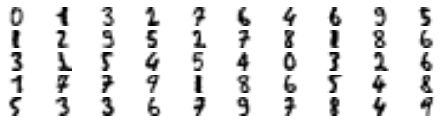

In [90]:
plt.figure(figsize=(8,2))
for index,X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k//10,10,index+1)
    plt.imshow(X_representative_digit.reshape(8,8), cmap="binary",interpolation="bilinear")
    plt.axis("off")
    
save_fig("representative_images_diagram", tight_layout=False)
plt.show()

#### 이미지를 보고 수동으로 레이블을 할당하여 학습해보기

In [91]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 1, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

In [93]:
log_reg =LogisticRegression(multi_class="ovr",solver="lbfgs",max_iter=5000,random_state=42)
log_reg.fit(X_representative_digits,y_representative_digits)
log_reg.score(X_test,y_test)

0.9244444444444444

#### 결과: 같은 50개의 샘플이지만 83% --> 92% 성능향상

#### 레이블전파(label propagation)

In [98]:
y_train_propagated = np.empty(len(X_train), dtype = np.int32)

for i in range(k): #k=n_clusters=50
    y_train_propagated[kmeans.labels_ ==i] =y_representative_digits[i]
    #각 센트로이드 값에 따라서 대표이미지 레이블값으로 레이블링해줌.

In [99]:
log_reg =LogisticRegression(multi_class="ovr",solver="lbfgs",max_iter=5000,random_state=42)
log_reg.fit(X_train,y_train_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [100]:
log_reg.score(X_test,y_test)

0.9377777777777778

#### 약간의 정확도 상승. 이번에는 센트로이드에 가까운 샘플(20%)에만 레이블을 전파해봄.

In [110]:
percentile_closest=20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
#dist목록에서 kmeas.label_에 해당하는 거리 (할당된 센트로이드 까지의 거리)

for i in range(k):
    in_cluster = (kmeans.labels_ ==i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist,percentile_closest)
    above_cutoff = (X_cluster_dist>cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] =-1
    
    

In [111]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [112]:
log_reg =LogisticRegression(multi_class='ovr',solver= "lbfgs", max_iter=5000,random_state=42)
log_reg.fit(X_train_partially_propagated,y_train_partially_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [113]:
log_reg.score(X_test,y_test)

0.9222222222222223

#### 전파된 레이블이 실제 레이블과 거의 99퍼센트 일치했기 때문에 좋은 성능을 얻음

In [115]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896193771626297

## 9.1.6 dbscan

#### 입실론 거리 안에 n개의 샘플이 있으면 핵심샘플로 판단.--> 같은 군집으로 이어나감

In [63]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=1000,noise = 0.05)
dbscan = DBSCAN(eps=0.05,min_samples=5) 
#eps = 입실론-이웃을 위한 거리 = 0.05.
#min_samples= 핵심샘플이 되게 위한입실론 이웃 안 최소샘플 수=5

dbscan.fit(X)


DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

#### 군집화 결과 확인

In [64]:
dbscan.labels_[:10]
#-1은 이상치로판단된것

array([0, 1, 2, 0, 0, 0, 3, 4, 7, 3])

In [65]:
len(dbscan.core_sample_indices_) #핵심샘플이 몇개인지

804

In [66]:
dbscan.core_sample_indices_[:10] #핵심샘플 인덱스

array([ 0,  1,  2,  4,  5,  6,  7,  9, 10, 11])

In [67]:
dbscan.components_[:3] #핵심샘플 자체는 components에 저장됨

array([[ 1.81493309, -0.06955507],
       [ 1.01377738,  0.1591774 ],
       [ 1.71467649, -0.17909484]])

#### 몇개의 군집으로 설정하였는지

In [69]:
np.unique(dbscan.labels_)
#-1은 이상치

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

#### dbscan은 알고리즘 특성상 새로운샘플의 군집 예측은 불가능. 따라서 knn과 같은 방법으로 간단하게 예측 가능

In [70]:
from sklearn.neighbors import KNeighborsClassifier

In [71]:
dbscan = DBSCAN(eps=0.2)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [72]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_,dbscan.labels_[dbscan.core_sample_indices_])
#핵심샘플, 핵심샘플 레이블

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

#### 새로운 샘플에 대해 예측

In [73]:
X_new = np.array([[-0.5,0],[0,0.5],[1,-0.1],[2,1]])
knn.predict(X_new)

array([1, 0, 1, 0])

#### 확률 

In [74]:
knn.predict_proba(X_new)

array([[0.16, 0.84],
       [1.  , 0.  ],
       [0.24, 0.76],
       [1.  , 0.  ]])

#### 몇개의 군집으로 예측했는지

In [44]:
np.unique(dbscan.labels_)

array([0, 1])

#### e=0.2일때, 훈련셋에 이상치가 없음. 따라서 knn은 주변에 이상치가 없어서 모두 클래스를 할당해줌. 따라서 예측 시 e=0.2이상일때 직접 이상치로 예측해줌 

In [222]:
y_dist,y_pred_idx =knn.kneighbors(X_new,n_neighbors=1)
#포인트의 가장 가까운 이웃과의 거리, 인덱스를 구함.

y_pred= dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
#해당 인덱스들의 dbscan 예측값 

print(dbscan.labels_[dbscan.core_sample_indices_][909])
print(dbscan.labels_[dbscan.core_sample_indices_][325])
print(dbscan.labels_[dbscan.core_sample_indices_][915])
print(dbscan.labels_[dbscan.core_sample_indices_][231])
#y_pred = [[1],[0],[1],[0]]
#y_dist = [[0.43045422],[0.02225568],[0.06010476],[0.48399468]]


y_pred[y_dist>0.2]=-1
#y_pred와 y_dist의 각 같은 인덱스에서 비교
#젤 가까운게 0.2보다 멀면 이상치(최근접 이웃이 eps=0.2보다 크니깐 이웃도 아니고 핵심도 아닌것.)
y_pred.ravel()
#평활화

(1000,)
0
1
0
0


array([-1,  0, -1, -1, -1,  1])

# 9.2 가우시안 혼합

#### 생성모델. 샘플이 파라미터가 알려지지 않은 여러개의 혼합 가우시안 분포에서 생성되었다고 가정.
하나의 가우시안 분포에서 생성된 모든 샘플은 하나의 클러스터(타원형)를 형성

EM(expectation-maximization) 알고리즘 사용

1.샘플을 클러스터에 할당(expectation)

2.클러스터를 업데이트(maximization step)

In [76]:
from sklearn.datasets import make_blobs

In [77]:
X1, y1 = make_blobs(n_samples=1000,centers=((4,-4),(0,0)),random_state=42)
X1 = X1.dot(np.array([[0.374,0.95], [0.732,0.598]]))

X2, y2 = make_blobs(n_samples=250, centers=1,random_state=42)
X2= X2+[6,-8]
X=np.r_[X1,X2]
y=np.r_[y1,y2]

In [78]:
from sklearn.mixture import GaussianMixture

In [79]:
gm = GaussianMixture(n_components=3,n_init=10,random_state=42)
#n_components 는 클러스터 개수
#n_init은 반복횟수(좋은결과 선택)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

#### 각 분포의 가중치(선택될 확률)

In [80]:
gm.weights_

array([0.39032584, 0.20961444, 0.40005972])

#### 각 분포의 평균 

In [81]:
gm.means_

array([[ 0.05145113,  0.07534576],
       [ 3.39947665,  1.05931088],
       [-1.40764129,  1.42712848]])

#### 각 분포의 공분산행렬 

In [83]:
gm.covariances_

array([[[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]]])

#### 수렴여부

In [84]:
gm.converged_

True

#### 반복횟수

In [85]:
gm.n_iter_

4

#### 하드군집(무조건 할당) 

In [86]:
gm.predict(X)

array([0, 0, 2, ..., 1, 1, 1])

#### 소프트군집(확률) 

In [88]:
gm.predict_proba(X)

array([[9.76815996e-01, 2.31833274e-02, 6.76282339e-07],
       [9.82914418e-01, 1.64110061e-02, 6.74575575e-04],
       [7.52377580e-05, 1.99781831e-06, 9.99922764e-01],
       ...,
       [4.31902443e-07, 9.99999568e-01, 2.12540639e-26],
       [5.20915318e-16, 1.00000000e+00, 1.45002917e-41],
       [2.30971331e-15, 1.00000000e+00, 7.93266114e-41]])

#### 샘플생성 (generative model)

In [89]:
X_new, y_new =gm.sample(6)
X_new

array([[-0.86951041, -0.32742378],
       [ 0.29854504,  0.28307991],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [-1.04030781,  0.78655831]])

In [90]:
y_new

array([0, 0, 1, 1, 1, 2])

#### 샘플 위치에서의 모델의 밀도
-->확률밀도함수 log값 

In [91]:
gm.score_samples(X)

array([-2.60786904, -3.57094519, -3.3302143 , ..., -3.51359636,
       -4.39793229, -3.80725953])

#### pdf를 적분하여 1이 되는지 확인

[[-10.    -9.99  -9.98 ...   9.97   9.98   9.99]
 [-10.   -10.   -10.   ...   9.99   9.99   9.99]]
[[-10.   -10.  ]
 [ -9.99 -10.  ]
 [ -9.98 -10.  ]
 ...
 [  9.97   9.99]
 [  9.98   9.99]
 [  9.99   9.99]]
(4000000, 2)


0.9999999999225095

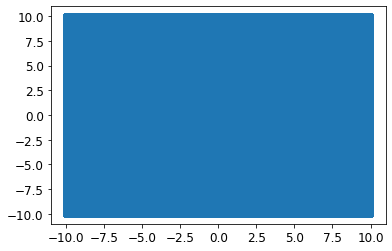

In [139]:
resolution =100
grid = np.arange(-10,10,1/resolution)
xx,yy = np.meshgrid(grid,grid)

x_full = np.c_[xx.ravel(), yy.ravel()]
print(x_full.T)
print(x_full)
print(x_full.shape)
plt.scatter(x_full[:,0],x_full[:,1])

pdf = np.exp(gm.score_samples(x_full))
#score_samples는 로그값이기 떄문에 지수함수 취하면 pdf값 나옴
pdf_probas =pdf*(1/resolution)**2
pdf_probas.sum()

#### draw_gaussian_mixture

In [166]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, 
                color=cross_color, zorder=11, alpha=1)


In [167]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer,X,resolution=1000,show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) +0.1
    xx,yy = np.meshgrid(np.linspace(mins[0],maxs[0],resolution),
                       np.linspace(mins[1],maxs[1],resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx,yy,Z,norm=LogNorm(vmin=1.0, vmax=30.0),
                levels= np.logspace(0,2,12))
    #경계색깔(알록달록)
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')
    #경계선(검정실선)
    Z =clusterer.predict(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape(xx.shape)
    plt.contour(xx,yy,Z,
               linewidths=2, colors='r', linestyles = 'dashed')
    #군집경계선(빨강)
    plt.plot(X[:,0],X[:,1],'k.',markersize=2)
    plot_centroids(clusterer.means_,clusterer.weights_)
    
    plt.xlabel("$x_1$",fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$",fontsize=14,rotation=0)
    else:
        plt.tick_params(labelleft=False)

그림 저장: gaussian_mixtures_plot


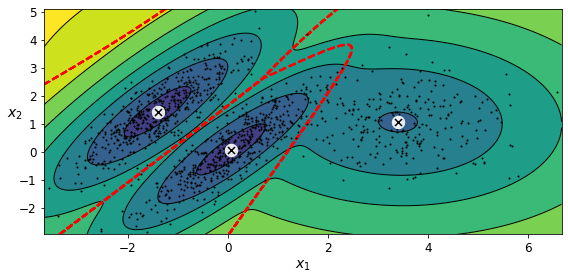

In [168]:
plt.figure(figsize=(8,4))

plot_gaussian_mixture(gm,X)
save_fig("gaussian_mixtures_plot")

plt.show()

#### 공분산 행렬에 제약조건

In [169]:
#covariance_type='full' : 제약없음
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_full.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [170]:
#covariance_type='tied' :모든 클러스터가 동일한 모양,크기,방향
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_tied.fit(X)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [171]:
#covariance_type='spherical' : 원형
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_spherical.fit(X)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [172]:
#covariance_type='diag' : 크기에 상관없는 타원. 공분산행렬이 대각행렬이라 타원이 축에 나란함.
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [176]:
def compare_gaussian_mixtures(gm1,gm2,X):
    plt.figure(figsize=(9,4))
    plt.subplot(121)
    plot_gaussian_mixture(gm1,X)
    plt.title("covariance_type ={}".format(gm1.covariance_type), fontsize=14)
    plt.subplot(122)
    plot_gaussian_mixture(gm2,X,show_ylabels=False)
    plt.title("covariance_type ={}".format(gm2.covariance_type), fontsize=14)
    

#### 1.tied vs spherical

tied는 같은크기,모양,방향 

spherical은 원형

그림 저장: covariance_type_plot


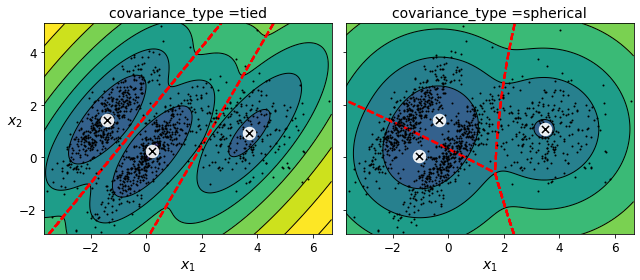

In [175]:
compare_gaussian_mixtures(gm_tied,gm_spherical,X)

save_fig("covariance_type_plot")
plt.show()


#### 2.full vs diag

full은 제약없음

diag는 축에 나란한 타원

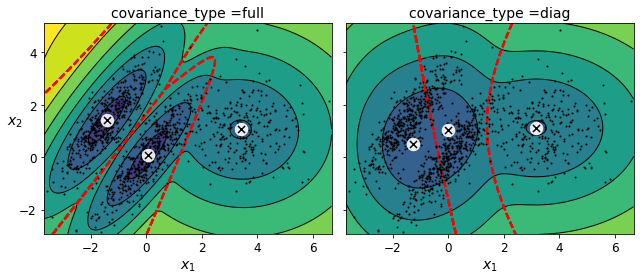

In [178]:
compare_gaussian_mixtures(gm_full,gm_diag,X)
plt.tight_layout()
plt.show()

## 9.2.1 가우시안 혼합을 사용한 이상치 탐지

#### 밀도가 낮은 지역(pdf)에 있는 샘플의 임계치를 이용

In [179]:
densities =gm.score_samples(X)
density_threshold =np.percentile(densities,4)
anomalies =X[densities<density_threshold]

그림 저장: mixture_anomaly_detection_plot


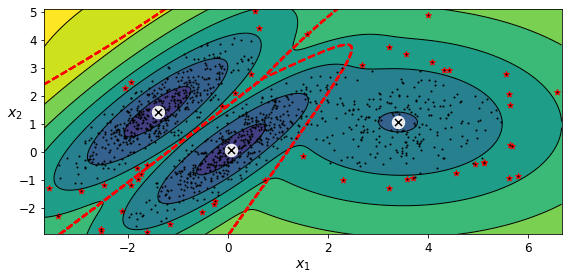

In [180]:
plt.figure(figsize=(8,4))

plot_gaussian_mixture(gm,X)
plt.scatter(anomalies[:,0],anomalies[:,1], color='r',marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

## 9.2.2 클러스터 개수 선택하기

#### BIC, AIC 를 최소화 하는 값.

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

$m$은 샘플의 개수입니다. --> 클수록 벌칙

$p$는 모델이 학습할 파라미터 개수입니다. --> 클수록 벌칙

$\hat L$은 모델의 가능도 함수의 최댓값입니다. --> 클수록 보상

이는 모델과 최적의 파라미터가 주어졌을 때 관측 데이터 $\mathbf{X}$의 조건부 확률입니다.

In [181]:
gm.bic(X)

8189.733705221634

In [182]:
gm.aic(X)

8102.508425106596

In [183]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10,random_state=42).fit(X) for k in range(1,11)]



In [185]:
bics = [i.bic(X) for i in gms_per_k]
aics = [i.aic(X) for i in gms_per_k]

그림 저장: aic_bic_vs_k_plot


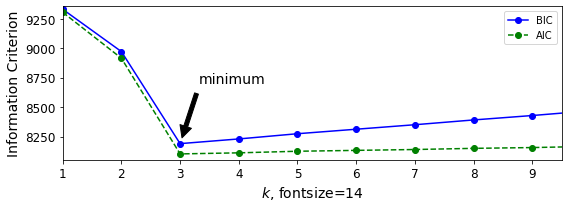

In [192]:
plt.figure(figsize=(8,3))
plt.plot(range(1,11), bics, "bo-", label="BIC")
plt.plot(range(1,11), aics, "go--", label = "AIC")
plt.xlabel("$k$, fontsize=14")
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1,9.5,np.min(aics)-50, np.max(aics)+50])
plt.annotate("minimum",
            xy=(3,bics[2]),
            xytext = (0.35,0.6),
            textcoords = "figure fraction",
            fontsize=14,
            arrowprops=dict(facecolor="black", shrink=0.1))
plt.legend(loc="upper right")
save_fig("aic_bic_vs_k_plot")
plt.show()

#### 클러스터 개수와 covariacne_type 하이퍼 파라미터의 최적 조합 탐색

In [195]:
min_bic =np.infty

for k in range(1,11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k,n_init=10,
                              covariance_type=covariance_type,
                             random_state=42).fit(X).bic(X)
        
        if bic<min_bic:
            min_bic =bic
            best_k = k
            best_covariance_type = covariance_type


In [196]:
best_k

3

In [197]:
best_covariance_type

'full'

## 9.2.3 베이즈 가우시안 혼합 모델

#### 클러스터 개수를 수동으로 찾지 않고(bic aic) 불필요한 클러스터의 가중치를 0으로 만드는 방법

클러스터 개수보다 크다고 믿을 값을 n_components로 지정하고 시작

In [200]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10, n_init=10,random_state=42)
bgm.fit(X)

/opt/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/mixture/_base.py:263: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

#### 자동으로 10개의 컴포턴트를 3개로 줄임

In [202]:
np.round(bgm.weights_,2)

array([0.4 , 0.  , 0.  , 0.  , 0.39, 0.2 , 0.  , 0.  , 0.  , 0.  ])

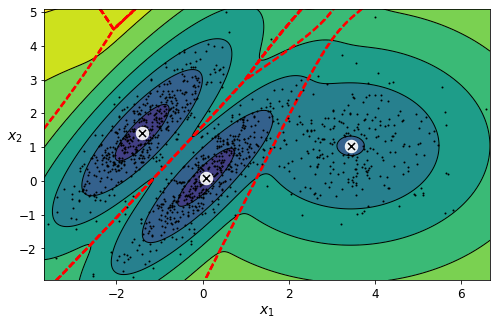

In [203]:
plt.figure(figsize=(8,5))
plot_gaussian_mixture(bgm,X)
plt.show()

#### 사전믿음 weight_concentration_prior 비교
beta(1,alpha) 에서 alpha값

작을수록 가중치 샘플링 시 1에서의 확률밀도가 커짐. 따라서 클러스터 줄어듦

클수록 가중치 샘플링 시 0에서의 확률밀도가 커짐 . 따라서 클러스터 많아짐

In [204]:
bgm_low =BayesianGaussianMixture(n_components=10,max_iter=1000, n_init=1,
                                weight_concentration_prior=0.01, random_state=42)
bgm_high= BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                 weight_concentration_prior=10000,
                                 random_state=42)

nn= 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1000, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=1,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=10000,
                        weight_concentration_prior_type='dirichlet_process')

#### 작은 사전믿음 alpha ==0.01. 클러스터가 적을것이다. 낮은농도

In [209]:
np.round(bgm_low.weights_,2)
#클러스터가 적음.

array([0.49, 0.51, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

#### 큰 사전믿음 alpha== 10000. 클러스터가 많을것이다. 낮은농도

In [210]:
np.round(bgm_high.weights_, 2)
#클러스터가 많음.

array([0.43, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01, 0.37, 0.01, 0.01])

그림 저장: mixture_concentration_prior_plot


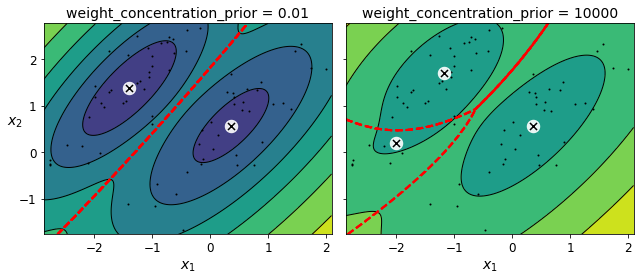

In [211]:
plt.figure(figsize=(9,4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low,X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high,X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()


#### 타원형 모양을 지향하기 때문에 다른 모양에서 잘 안됨

In [212]:
X_moons , y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42) 

In [213]:
bgn = BayesianGaussianMixture(n_components=10,n_init=10,random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

그림 저장: moons_vs_bgm_plot


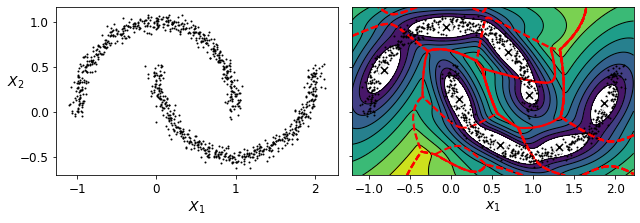

In [216]:
plt.figure(figsize=(9,3.2))

plt.subplot(121)
plt.plot(X_moons[:,0],X_moons[:,1],"k.",markersize=2)
plt.xlabel("$X_1$",fontsize=14)
plt.ylabel("$X_2$",fontsize=14,rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm,X_moons,show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

# 연습문제10. 올리베타 얼굴 데이터셋 군집하기

#### 문제: 전통적인 올리베티 얼굴 데이터셋은 64×64 픽셀 크기의 흑백 얼굴 이미지 400개를 담고 있습니다. 각 이미지는 4,096 크기의 1D 벡터로 펼쳐져 있습니다. 사람 40명의 사진을 10장씩 찍은 것입니다. 어떤 사람의 사진인지 예측하는 모델을 훈련하는 것이 일반적입니다. sklearn.datasets.fetch_olivetti_faces() 함수를 사용해 데이터셋을 불러오세요.

In [223]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/koosup/scikit_learn_data


In [225]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [226]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

#### 문제: 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(이 데이터셋은 이미 0에서 1 사이로 스케일이 조정되어 있습니다). 이 데이터셋은 매우 작으니 계층적 샘플링을 사용해 각 세트에 동일한 사람의 얼굴이 고루 섞이도록 하는 것이 좋습니다.

In [228]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1,test_size=40,random_state=42)
train_valid_idx,test_idx =next(strat_split.split(olivetti.data, olivetti.target))

X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]

X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1,test_size=80,random_state=43)
train_idx,valid_idx = next(strat_split.split(X_train_valid,y_train_valid))

X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]

X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [229]:
print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)
print(X_test.shape,y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


#### 속도를 높이기 위해 PCA로 데이터의 차원을 줄입니다:
이미지는 차원이 매우 크기때문. 이경우엔 4096

In [230]:
from sklearn.decomposition import PCA

In [232]:

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

#### 문제: 그다음 k-평균을 사용해 이미지를 군집해보세요. (이 장에서 소개한 기법 중 하나를 사용해) 적절한 클러스터 개수를 찾아보세요.

In [233]:
from sklearn.cluster import KMeans

k_range = range(5,150,5)
kmeans_per_k = []

for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)    

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


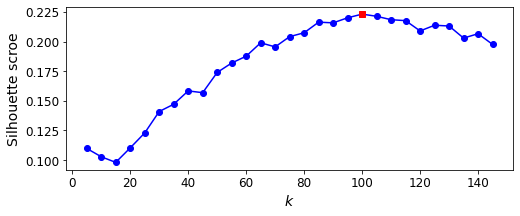

In [235]:
from sklearn.metrics import silhouette_score

silhouette_scores =[silhouette_score(X_train_pca,model.labels_) for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8,3))
plt.plot(k_range, silhouette_scores,"bo-")
plt.xlabel("$k$",fontsize=14)
plt.ylabel("Silhouette scroe",fontsize=14)
plt.plot(best_k,best_score,"rs")
plt.show()

In [236]:
best_k

100

####  best_k가 인물 수 40보다 훨씬 큰 100임. 이너셔를 활용하여 엘보포인트도 확인해보겠음.

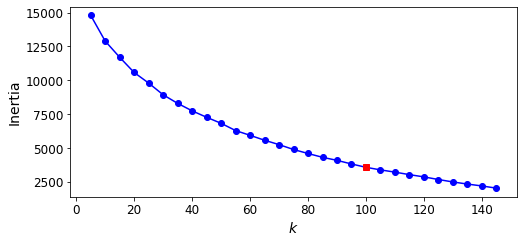

In [238]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8,3.5))
plt.plot(k_range,inertias,"bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k,best_inertia,"rs")
plt.show()

#### 특별한 엘보포인트도 확인이 되지 않기때문에 100을 그냥 사용

In [239]:
best_model = kmeans_per_k[best_index]

cluster 0


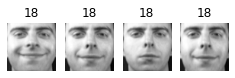

cluster 1


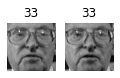

cluster 2


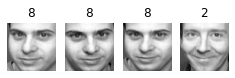

cluster 3


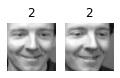

cluster 4


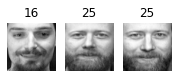

cluster 5


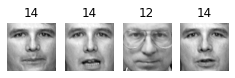

cluster 6


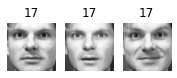

cluster 7


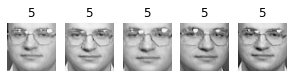

cluster 8


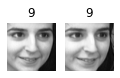

cluster 9


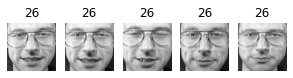

cluster 10


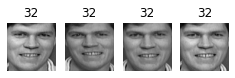

cluster 11


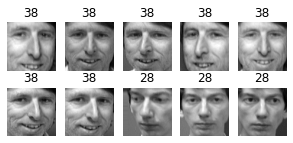

cluster 12


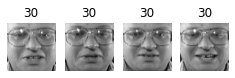

cluster 13


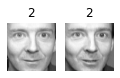

cluster 14


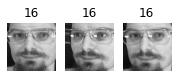

cluster 15


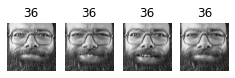

cluster 16


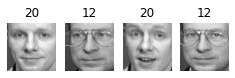

cluster 17


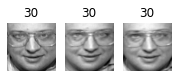

cluster 18


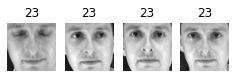

cluster 19


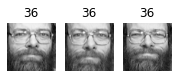

cluster 20


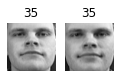

cluster 21


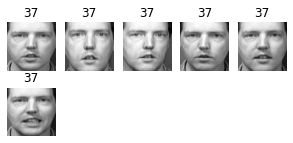

cluster 22


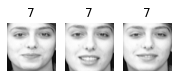

cluster 23


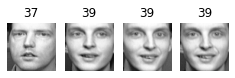

cluster 24


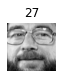

cluster 25


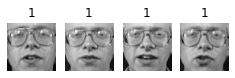

cluster 26


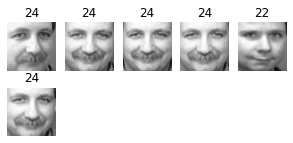

cluster 27


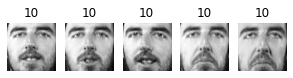

cluster 28


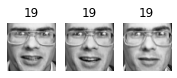

cluster 29


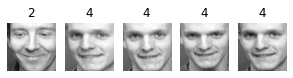

cluster 30


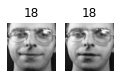

cluster 31


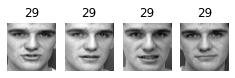

cluster 32


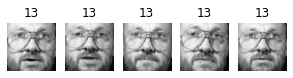

cluster 33


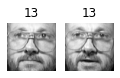

cluster 34


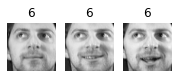

cluster 35


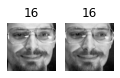

cluster 36


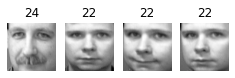

cluster 37


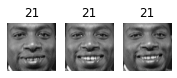

cluster 38


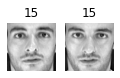

cluster 39


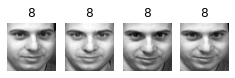

cluster 40


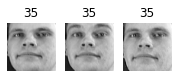

cluster 41


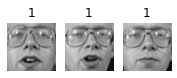

cluster 42


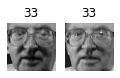

cluster 43


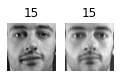

cluster 44


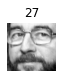

cluster 45


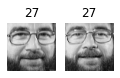

cluster 46


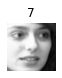

cluster 47


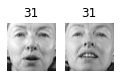

cluster 48


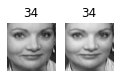

cluster 49


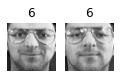

cluster 50


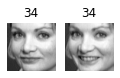

cluster 51


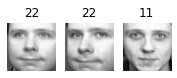

cluster 52


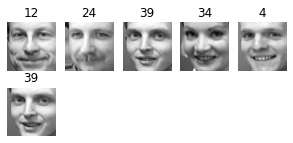

cluster 53


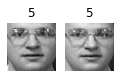

cluster 54


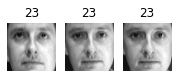

cluster 55


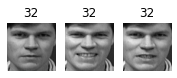

cluster 56


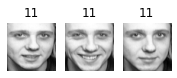

cluster 57


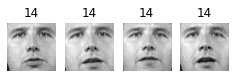

cluster 58


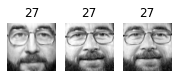

cluster 59


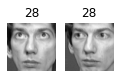

cluster 60


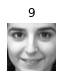

cluster 61


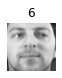

cluster 62


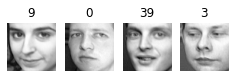

cluster 63


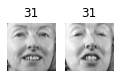

cluster 64


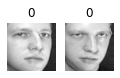

cluster 65


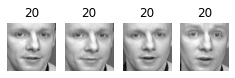

cluster 66


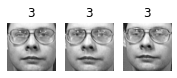

cluster 67


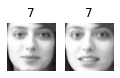

cluster 68


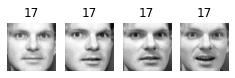

cluster 69


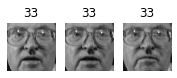

cluster 70


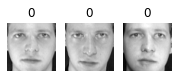

cluster 71


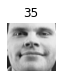

cluster 72


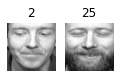

cluster 73


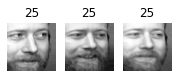

cluster 74


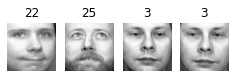

cluster 75


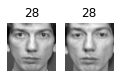

cluster 76


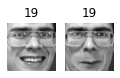

cluster 77


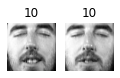

cluster 78


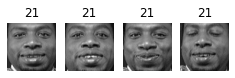

cluster 79


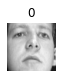

cluster 80


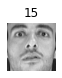

cluster 81


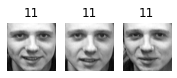

cluster 82


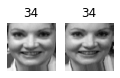

cluster 83


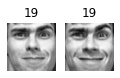

cluster 84


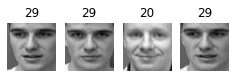

cluster 85


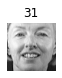

cluster 86


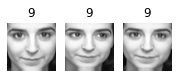

cluster 87


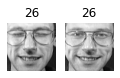

cluster 88


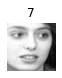

cluster 89


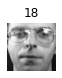

cluster 90


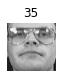

cluster 91


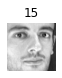

cluster 92


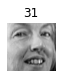

cluster 93


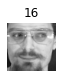

cluster 94


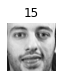

cluster 95


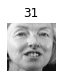

cluster 96


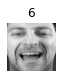

cluster 97


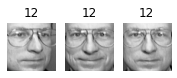

cluster 98


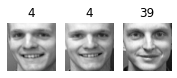

cluster 99


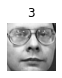

In [243]:
def plot_faces(faces,labels,n_cols=5):
    n_rows = (len(faces)-1) // n_cols +1
    plt.figure(figsize=(n_cols,n_rows*1.1))
    for index, (face,label) in enumerate(zip(faces,labels)):
        plt.subplot(n_rows,n_cols,1+index)
        plt.imshow(face.reshape(64,64), cmap ="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()
    
for cluster_id in np.unique(best_model.labels_):
    print("cluster",cluster_id)
    in_cluster =best_model.labels_==cluster_id
    faces =X_train[in_cluster].reshape(-1,64,64)
    labels =y_train[in_cluster]
    plot_faces(faces,labels)
        

#### 하나의 사진만 있는 클러스터가 많음. 사용하기는 어려움. 이미지를 레이블링 할때는 쓸만함

# 연습문제11. 분류를 위해 군집으로 전처리하기

#### 문제: 올리베티 얼굴 데이터셋으로 계속해보겠습니다. 사진에 나타난 사람을 예측하는 분류기를 훈련하고 검증 세트에서 평가해보세요.

In [244]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca,y_train)
clf.score(X_valid_pca, y_valid)

0.9

#### 문제: 그다음 k-평균을 차원 축소 도구로 사용하여 축소된 세트에서 분류기를 훈련해보세요.

In [249]:
X_train_reduced =best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150,random_state=42)
clf.fit(X_train_reduced,y_train)
clf.score(X_valid_reduced,y_valid)

0.75

#### 문제: 분류기 성능을 최대로 만드는 클러스터 개수를 찾아보세요. 얼마나 성능이 나오나요?

In [250]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline =Pipeline([
        
        ("kmeans",KMeans(n_clusters=n_clusters, random_state=n_clusters)),
        ("forest_clf",RandomForestClassifier(n_estimators=150,random_state=42))       
    ])
    pipeline.fit(X_train_pca,y_train)
    print(n_clusters,pipeline.score(X_valid_pca,y_valid))
    
    

5 0.3375
10 0.5375
15 0.5875
20 0.6625
25 0.65
30 0.7375
35 0.725
40 0.75
45 0.6875
50 0.7
55 0.725
60 0.775
65 0.7625
70 0.7
75 0.7625
80 0.725
85 0.7125
90 0.7125
95 0.75
100 0.75
105 0.7375
110 0.75
115 0.7375
120 0.7125
125 0.7625
130 0.7375
135 0.775
140 0.8
145 0.75


#### 모두 80을 넘지 못함.(pca만 했을때가 90)

따라서 센트로이드 까지의 거리는 원본이미지 만큼 유용하지 못함!!!!

#### 문제: 축소된 세트에서 추출한 특성을 원본 특성에 추가하면 어떤가요? (여기에서도 최선의 클러스터 개수를 찾아보세요.)

In [251]:
X_train_extended = np.c_[X_train_pca,X_train_reduced]
X_valid_extended = np.c_[X_valid_pca,X_valid_reduced]
X_test_extended = np.c_[X_test_pca,X_test_reduced]

In [252]:
clf = RandomForestClassifier(n_estimators=150,random_state=42)
clf.fit(X_train_extended,y_train)
clf.score(X_valid_extended,y_valid)

0.825

#### 조금 낫지만 역시 그냥 pca(90%)보다 안좋음.

# 12. 올리베리 얼굴 데이터셋을 위한 가우시안 혼합 모델

#### 문제: 올리베티 얼굴 데이터셋에서 가우시안 혼합 모델을 훈련해보세요. 알고리즘의 속도를 높이기 위해 데이터셋의 차원을 감소시켜야 할 것입니다(예를 들면 분산의 99%를 유지하면서 PCA를 사용합니다).

In [253]:
from sklearn.mixture import GaussianMixture

gm =GaussianMixture(n_components=40,random_state=42)
y_pred = gm.fit_predict(X_train_pca)

#### 문제: 이 모델을 사용해 (sample() 메서드로) 새로운 얼굴을 생성하고 시각화해보세요(PCA를 사용했다면 inverse_transform() 메서드를 사용해야 합니다).

In [254]:
n_gen_faces=20

gen_faces_reduced,y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

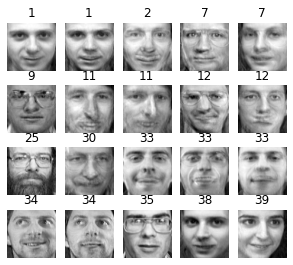

In [255]:
plot_faces(gen_faces,y_gen_faces)

#### 
문제: 일부 이미지를 수정해보세요(예를 들면 회전, 뒤집기, 어둡게 하기). 모델이 이상치를 감지하는지 확인해보세요(즉 정상 샘플과 이상치에 대해 score_samples() 메서드 출력을 비교해보세요).

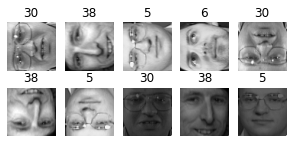

In [256]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 64*64)
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [257]:
X_bad_faces_pca = pca.transform(X_bad_faces)

#### 잘못된 사진은 이 가우시안 모델에서 등장할 가능성이 매우 낮음(확률밀도 낮음)

In [258]:
gm.score_samples(X_bad_faces_pca)

array([-1.79997585e+07, -2.26427923e+07, -3.96415668e+07, -4.60254426e+07,
       -3.13975665e+07, -1.39329810e+07, -2.90883096e+07, -1.06298715e+08,
       -1.20931196e+08, -7.49740876e+07])

In [259]:
gm.score_samples(X_train_pca[:10])

array([1163.02020811, 1149.16681692, 1148.47710772, 1170.67602928,
       1088.46009914, 1075.71700371, 1075.71700806, 1088.46009289,
       1096.42609684, 1119.68626675])

# 13. 차원 축소 기법을 사용해 이상치 탐지하기

#### 문제: 일부 차원 축소 기법은 이상치 탐지를 위해서 사용할 수도 있습니다. 예를 들어 올리베티 얼굴 데이터셋을 PCA를 사용해 분산의 99% 유지하도록 축소해보세요. 그다음 각 이미지의 재구성 오차를 계산합니다. 그다음 이전 연습문제에서 만든 수정된 이미지를 선택해 재구성 오차를 확인해보세요. 재구성 오차가 얼마나 커지는지 확인하세요. 재구성 이미지를 출력해보면 이유를 알 수 있습니다. 정상 얼굴을 재구성하기 때문입니다.

In [260]:
X_train_pca

array([[ 3.7808321e+00, -1.8547790e+00, -5.1440277e+00, ...,
        -1.3562325e-01, -2.1408355e-01,  6.1186515e-02],
       [ 1.0148822e+01, -1.5275446e+00, -7.6703393e-01, ...,
         1.2393360e-01, -1.3526942e-01, -2.3266854e-02],
       [-1.0015291e+01,  2.8772719e+00, -9.1988486e-01, ...,
         7.2607487e-02, -2.9597613e-03,  1.2488555e-01],
       ...,
       [ 2.4758611e+00,  2.9559693e+00,  1.2998576e+00, ...,
        -2.0903669e-02,  3.4857798e-02, -1.5433593e-01],
       [-3.2203157e+00,  5.3489776e+00,  1.3942631e+00, ...,
         5.7549786e-02, -2.2831374e-01,  1.5557544e-01],
       [-9.2287493e-01, -3.6470284e+00,  2.2608831e+00, ...,
         1.3684890e-01, -6.9136895e-02,  6.2694617e-02]], dtype=float32)

In [261]:
def reconstruction_errors(pca,X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed-X).mean(axis=-1)
    return mse

In [262]:
reconstruction_errors(pca,X_train).mean()

0.0001920535

#### 재구성오차가 40배는 커짐 --> pca를 통해 이상치 검출!!

In [265]:
reconstruction_errors(pca, X_bad_faces).mean()

0.0047073537

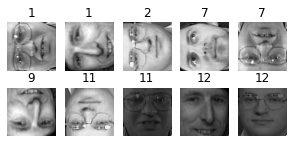

In [266]:
plot_faces(X_bad_faces, y_gen_faces)

#### 수정된 이미지를 재구성해서 플롯해봄 ㅎㅎ

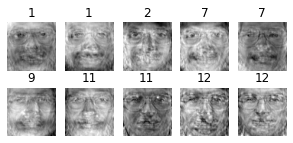

In [268]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_gen_faces)